# Implémentez un modèle de scoring


Etude data - Projet 7 - Fevrier 2023

*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

## Code de la modélisation
Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un CPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. 


---

In [142]:
!pip install catboost 

In [143]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [144]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [145]:
z = ZipFile("data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 341)

In [146]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [148]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 341), (92254, 341), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [149]:
from sklearn.linear_model import LogisticRegression

In [150]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20, 15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    show()

In [151]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6941
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: total: 5.98 s
Wall time: 7.57 s


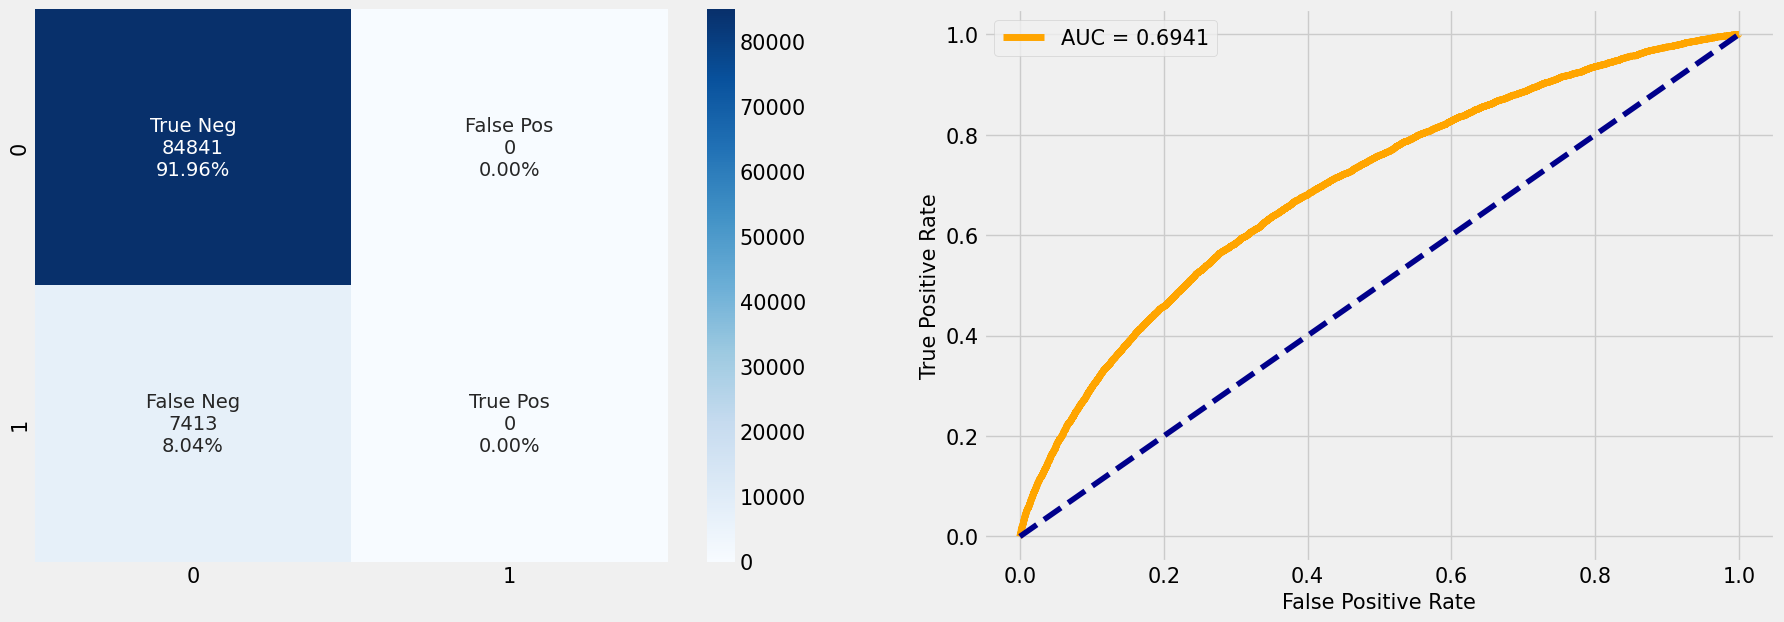

In [152]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

# **Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [153]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [154]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: total: 19.4 s
Wall time: 8.94 s


In [155]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [156]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7194
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: total: 14.9 s
Wall time: 16 s


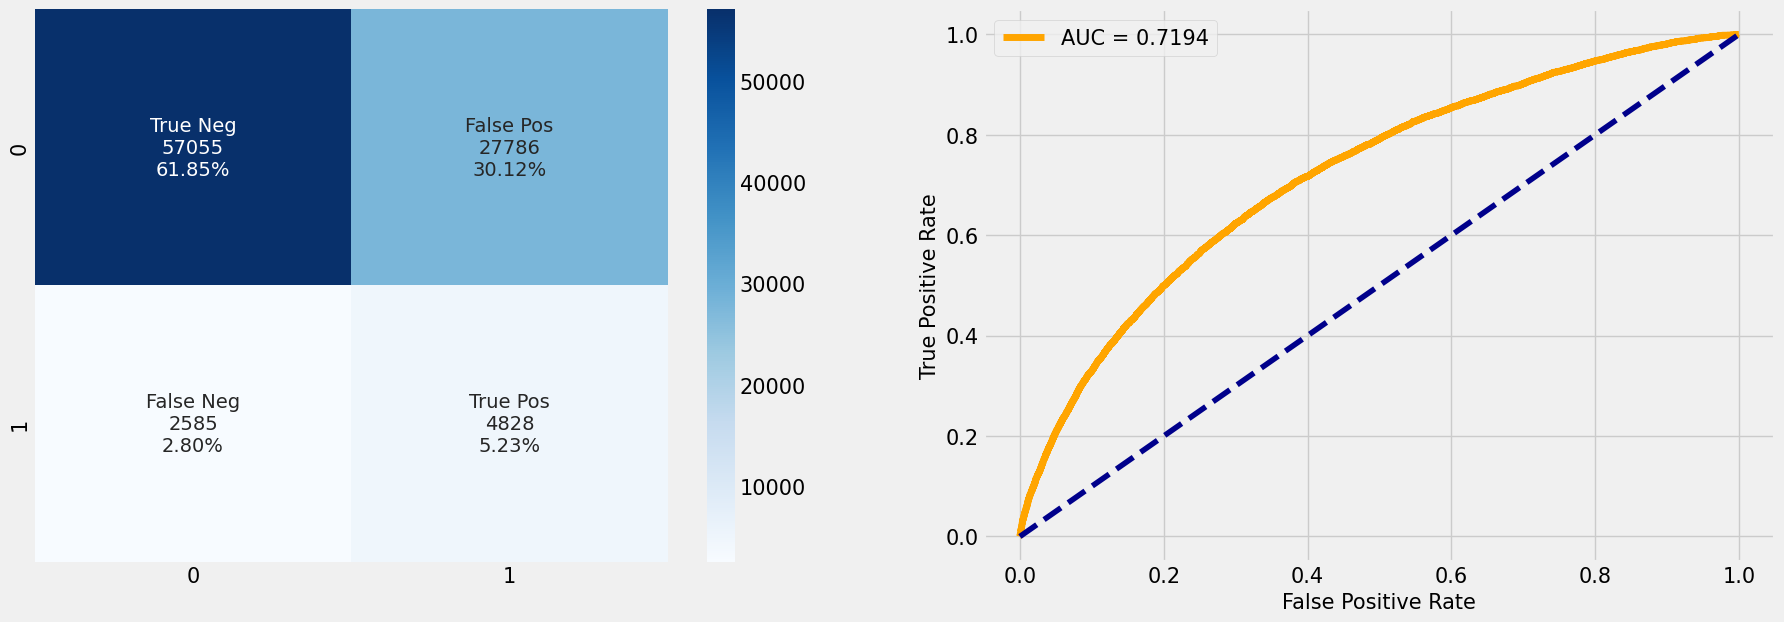

In [157]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### **Gradient Boosting**

In [158]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(task_type="CPU", logging_level='Silent'),
          LGBMClassifier(device='cpu'),
          XGBClassifier(tree_method='hist', predictor='cpu_predictor')]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [159]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [160]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 54min 46s
Wall time: 18min 51s


In [161]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.779214,0.920036,0.525281,0.050452,0.092062,422.626211
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,587.094796
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,121.632684


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [162]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 28min 2s
Wall time: 13min 19s


In [163]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.772436,0.919429,0.487562,0.05288,0.095412,737.891966
2,XGBClassifier,0.753372,0.917901,0.417773,0.055173,0.097474,24.656809
1,LGBMClassifier,0.752837,0.919082,0.424419,0.019695,0.037643,36.530343


LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### **Feature Selection - Recursive Feature Elimination**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [164]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 341 features.
Fitting estimator with 336 features.
Fitting estimator with 331 features.
Fitting estimator with 326 features.
Fitting estimator with 321 features.
Fitting estimator with 316 features.
Fitting estimator with 311 features.
Fitting estimator with 306 features.
Fitting estimator with 301 features.
Fitting estimator with 296 features.
Fitting estimator with 291 features.
Fitting estimator with 286 features.
Fitting estimator with 281 features.
Fitting estimator with 276 features.
Fitting estimator with 271 features.
Fitting estimator with 266 features.
Fitting estimator with 261 features.
Fitting estimator with 256 features.
Fitting estimator with 251 features.
Fitting estimator with 246 features.
Fitting estimator with 241 features.
Fitting estimator with 236 features.
Fitting estimator with 231 features.
Fitting estimator with 226 features.
Fitting estimator with 221 features.
Fitting estimator with 216 features.
Fitting estimator with 211 features.
F

In [165]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 121
Selected Features: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1 15  3  1  1  1  1  1  1  1  1  1  1 17 17  1 18 18 11]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [166]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

121
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_AMT_CREDIT', 'PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE_x', 'PREV_APPL_MEAN_AMT_APPLICATION', 'PREV_APPL_MEAN_AMT_ANNUITY', 'PREVIOUS_APPLICATION_COUNT', 'PREV_BUR_MEAN_MONTHS_BALANCE_MEAN', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE_x', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERD

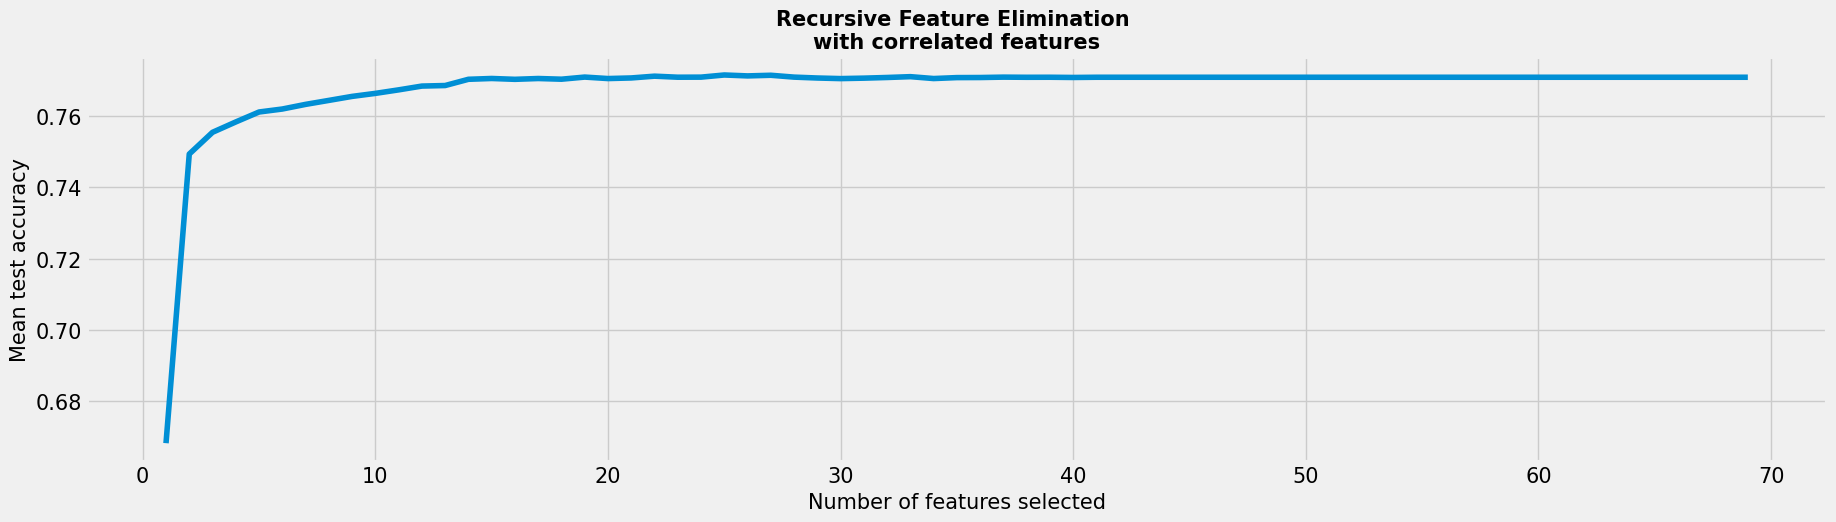

In [167]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize(20, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    #yerr=rfecv.cv_results_["std_test_score"],
)
plt.title('Recursive Feature Elimination \nwith correlated features')
plt.show()


RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [168]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 121)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [169]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [170]:
X_data.shape

(307511, 122)

In [171]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)

CPU times: total: 50.6 s
Wall time: 59.9 s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [172]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)

CPU times: total: 5.36 s
Wall time: 6.11 s


In [173]:
%%time
X_data.sample(10000).to_csv('X_sample.csv', index=True)

CPU times: total: 734 ms
Wall time: 1.42 s


In [174]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [175]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="CPU", logging_level='Silent'),
          LGBMClassifier(device='cpu'),
          XGBClassifier(tree_method='hist', predictor='cpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [176]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 3min 43s
Wall time: 1min 4s


In [177]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.77792,0.919722,0.504965,0.048024,0.087706,53.729295
1,LGBMClassifier,0.774411,0.920177,0.555305,0.033185,0.062627,5.645088
2,XGBClassifier,0.763946,0.919093,0.47099,0.055848,0.099855,4.979855


In [178]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.779214,0.920036,0.525281,0.050452,0.092062,422.626211
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,587.094796
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,121.632684


**LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



In [179]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [180]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [181]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [119]:
!pip install hyperopt


In [120]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [121]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [122]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'cpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [123]:
%%time
trials = Trials()
#best = fmin(fn=objective, space=space,
                             #algo=tpe.suggest, max_evals=30, verbose=1,rstate=np.random.RandomState)
#best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)
best = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=30,trials=trials)

100%|████████████████████████████████████████████████| 30/30 [18:57<00:00, 37.91s/trial, best loss: 0.9769388194477095]
CPU times: total: 4h 33min 48s
Wall time: 18min 57s


In [124]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb"))

CPU times: total: 3min 27s
Wall time: 14.1 s


In [125]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779744


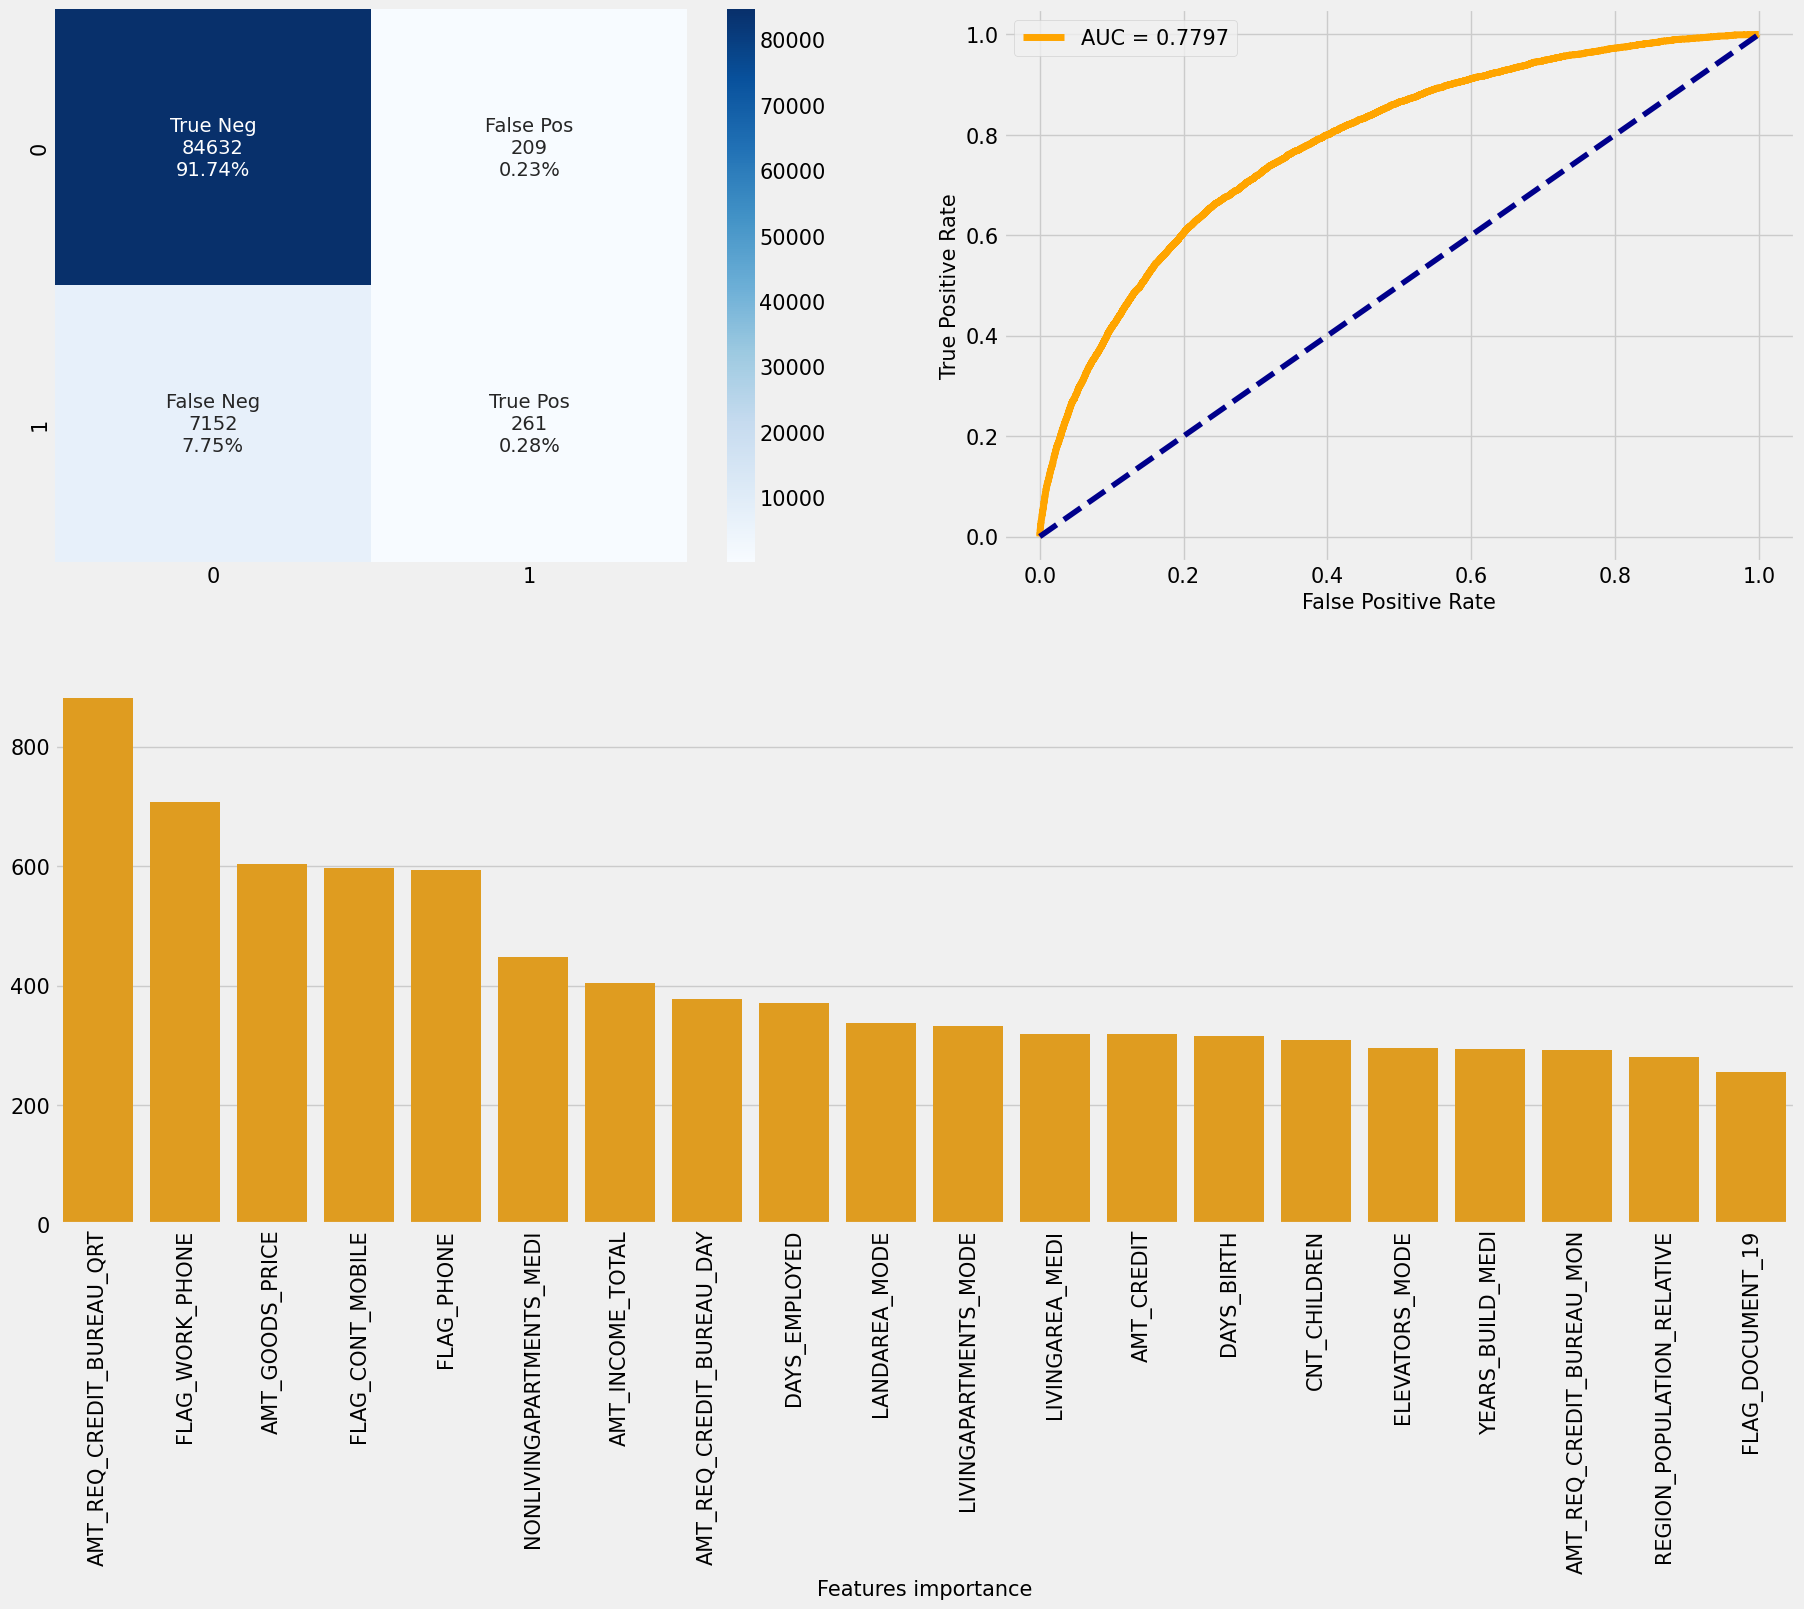

In [126]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [127]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.23%
False Neg: 7.75%


(0.002265484423439634, 0.07752509376287207)

In [128]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 881]
['EXT_SOURCE_1', 707]
['DAYS_BIRTH', 604]
['EXT_SOURCE_2', 597]
['EXT_SOURCE_3', 593]
['PREV_APPL_MEAN_CNT_PAYMENT', 447]
['AMT_ANNUITY', 405]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT_x', 378]
['DAYS_ID_PUBLISH', 370]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 337]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 332]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 319]
['AMT_GOODS_PRICE', 319]
['DAYS_REGISTRATION', 316]
['AMT_CREDIT', 309]
['PREV_BUR_MEAN_DAYS_CREDIT', 295]
['PREV_APPL_MEAN_AMT_ANNUITY', 294]
['ANNUITY_INCOME_PERCENT', 292]
['DAYS_EMPLOYED', 280]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER_x', 255]
['DAYS_EMPLOYED_PERCENT', 245]
['DAYS_LAST_PHONE_CHANGE', 244]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 240]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 238]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 229]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION_x', 224]
['CREDIT_INCOME_PERCENT', 218]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 210]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT_

In [129]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'cpu'}
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [131]:
%%time
#best = fmin(fn=objective, space=space,
                             #algo=tpe.suggest, max_evals=30, verbose=1,rstate=np.random.RandomState)
#best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)
best = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=30,trials=trials)
#best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?trial/s, best loss=?]
CPU times: total: 0 ns
Wall time: 8.96 ms


In [132]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu')

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_models/LGBMClassifier.pkl", "wb"))

CPU times: total: 3min 26s
Wall time: 14.6 s


LGBMClassifier(colsample_bytree=0.7489506705716142, device='cpu',
               learning_rate=0.027520915845577105, max_depth=7,
               n_estimators=600, reg_lambda=6.767666353925936,
               subsample=0.7142982812396307)

In [133]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779744


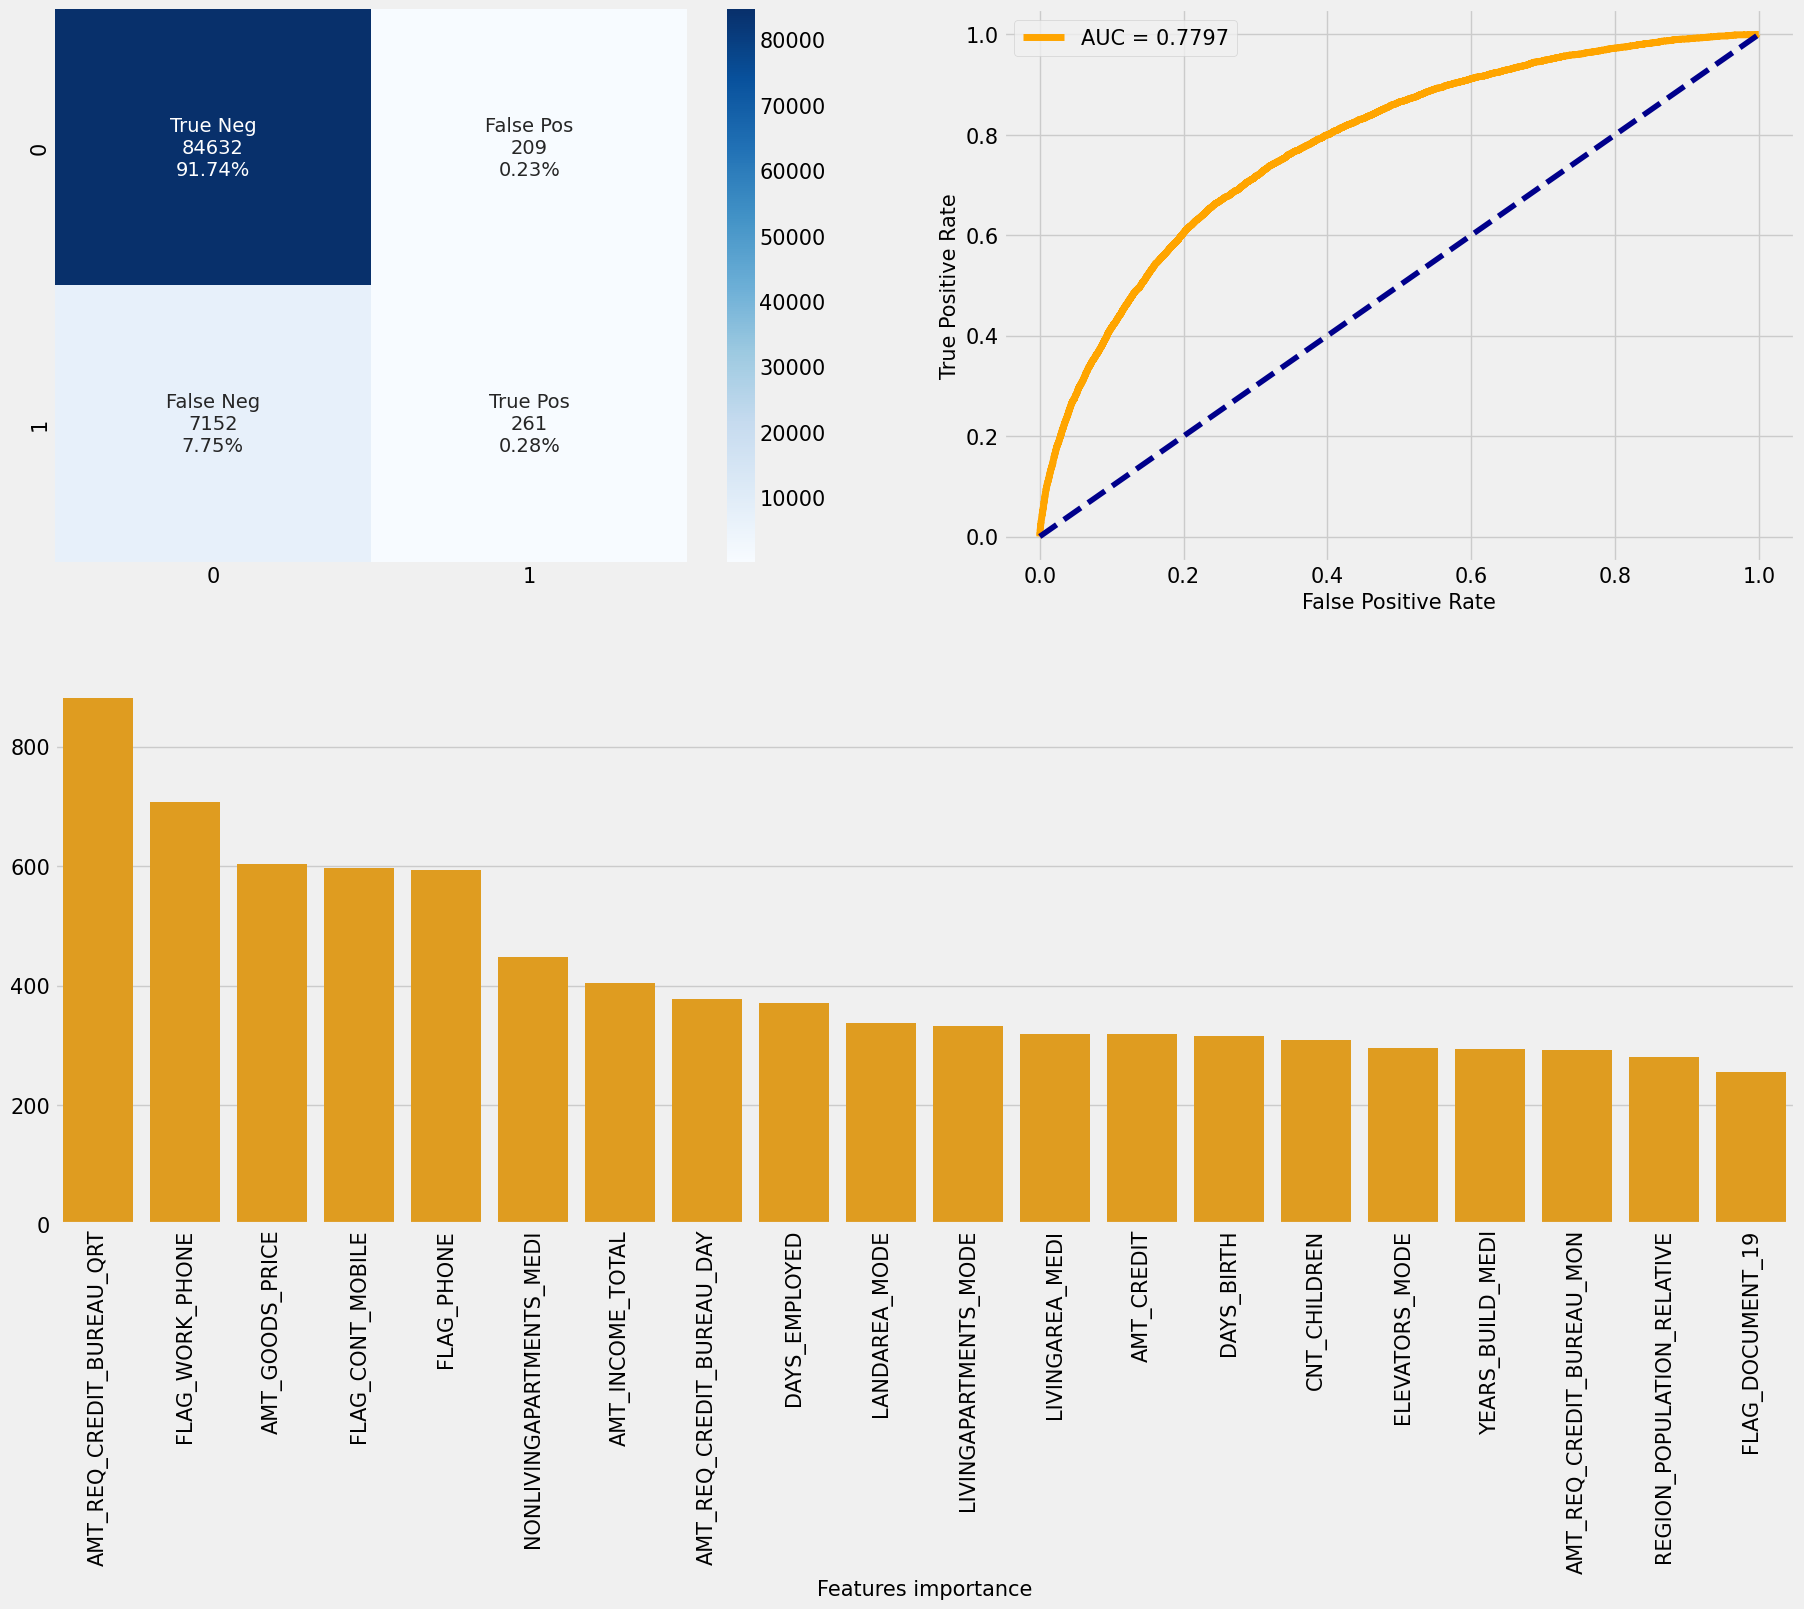

In [134]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [135]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.23%
False Neg: 7.75%


(0.002265484423439634, 0.07752509376287207)

In [136]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 881]
['EXT_SOURCE_1', 707]
['DAYS_BIRTH', 604]
['EXT_SOURCE_2', 597]
['EXT_SOURCE_3', 593]
['PREV_APPL_MEAN_CNT_PAYMENT', 447]
['AMT_ANNUITY', 405]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT_x', 378]
['DAYS_ID_PUBLISH', 370]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 337]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 332]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 319]
['AMT_GOODS_PRICE', 319]
['DAYS_REGISTRATION', 316]
['AMT_CREDIT', 309]
['PREV_BUR_MEAN_DAYS_CREDIT', 295]
['PREV_APPL_MEAN_AMT_ANNUITY', 294]
['ANNUITY_INCOME_PERCENT', 292]
['DAYS_EMPLOYED', 280]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER_x', 255]
['DAYS_EMPLOYED_PERCENT', 245]
['DAYS_LAST_PHONE_CHANGE', 244]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 240]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 238]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 229]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION_x', 224]
['CREDIT_INCOME_PERCENT', 218]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 210]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT_

In [297]:
!pip install shap

# Features importance SHAP

Les valeurs de Shapley calculent l’importance d’une variable en comparant la sortie qu’un modèle peut prédire avec et sans cette variable. Cependant, étant donné que l’ordre dans lequel un modèle voit les variables peut affecter ses prédictions, cela se fait dans tous les ordres possibles, afin que les fonctionnalités soient comparées équitablement. Cette approche est inspirée de la théorie des jeux.

SHAP s’utilise pour expliquer un modèle existant. Prenant un cas de classification binaire construite avec un modèle sklearn. On entraine, tune et teste notre modèle. Ensuite on peut utiliser nos données et le modèle pour créer un modèle supplémentaire de SHAP qui explique notre modèle de classification.

Les valeurs Shap sont des tableaux d'une longueur correspondant au nombre de classes dans la cible. Ici, le problème est la classification binaire, et donc les valeurs Shap ont deux tableaux correspondant à l'une ou l'autre classe.

Les valeurs Shap sont des nombres à virgule flottante correspondant aux données de chaque ligne correspondant à chaque caractéristique. La valeur Shap représente la contribution de ce point de données particulier dans la prédiction des sorties. Si la valeur shap est très proche de zéro, on peut dire que le point de données contribue très peu aux prédictions. Si la valeur shap est une valeur fortement positive ou fortement négative, nous pouvons dire que le point de données contribue grandement à la prédiction de la classe positive ou négative.

In [186]:
import shap

In [ ]:
%time 
#shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)
shap_values = shap.TreeExplainer(lgbm).shap_values(X_test_selected)

CPU times: total: 0 ns
Wall time: 0 ns


In [294]:
#lgbm.feature_importances = np.abs(shap_values).mean(0)[:-1]

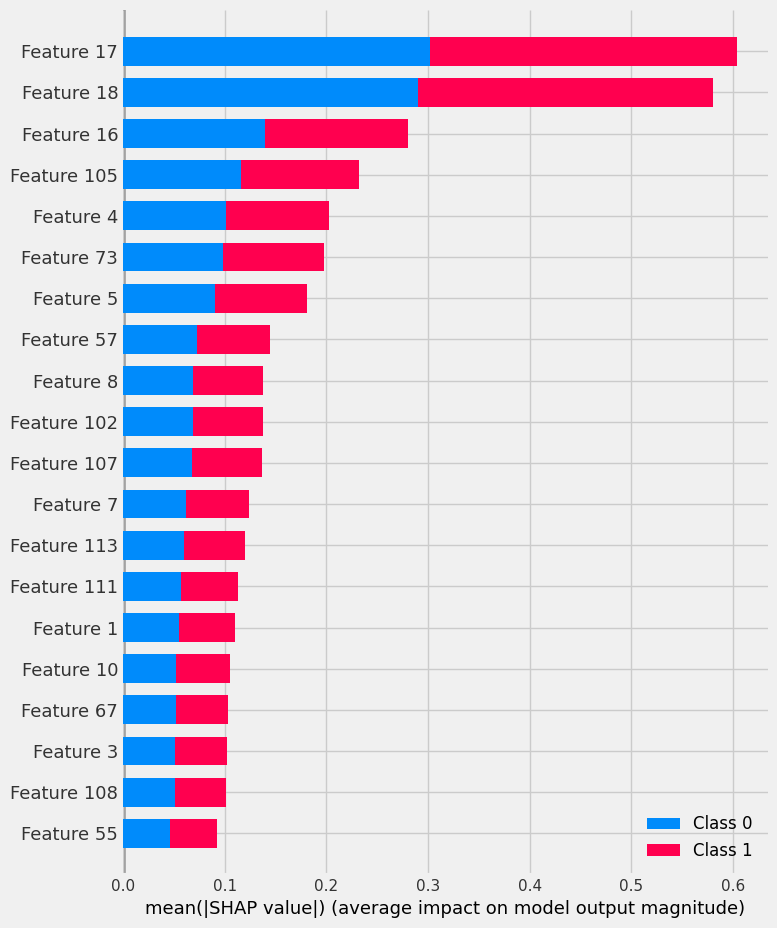

In [295]:
shap.summary_plot(shap_values, X_test_selected)

Avec ce graphique, nous pouvons voir que nous retrouvons les EXT_SOURCES 1, 2 et 3 ainsi que CREDIT_REFUND_TIME. Un peu plus bas nous retrouvons DAYS_BIRTHS même si il semble jouer un rôle moins important pour le fait qu'une personne soit non solvable. Dans cette nouvelle représentation, le Genre du client est important dans la prédiction mais nous ne le prendrons pas en compte car cette information ferait de notre modèle un modèle discriminant. Nous trouvons également un rôle important pour la variable AMT_GOODS_PRICE qui correspond au montant du prix des biens pour lesquels le prêt est accordé pour les prêts de consommation qui ne sera pas pris en compte car le choix peut être biaisé et le crédit ne pourrait pas être accordé si le biens est trop cher.

Nous prendrons donc en comte les features EXT_SOURCES 1, 2, 3 ainsi que CREDIT_REFUND_TIME et l'âge.

Voyons plus en détail l'influence de chacune de ces variables sur la prédiction de non solvabilité.

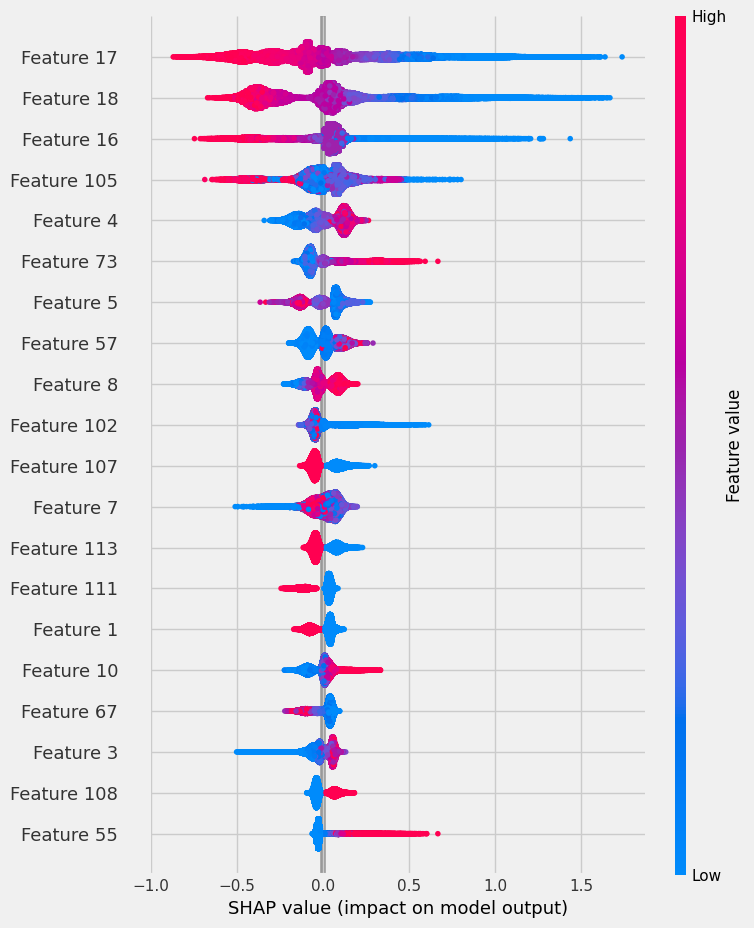

In [296]:
shap.summary_plot(shap_values[1], X_test_selected.astype("float"))

Nous traçons les valeurs SHAP de chaque caractéristique pour chaque échantillon sur l'axe des x, puis nous les laissons s'accumuler. Si nous colorons ensuite chaque point selon sa valeur, nous pouvons voir comment une valeur faible ou élevée affecte la sortie du modèle.

Pour EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1 on peut voir que de faibles valeurs augmentent de manière significative la sortie de probabilité du modèle et donc le fait d'être non solvable.

Au contraire, pour CREDIT_REFUND_TIME, plus le temps de remboursement des crédits est grand plus il a de chance que le prêt ne lui soit pas accordé.

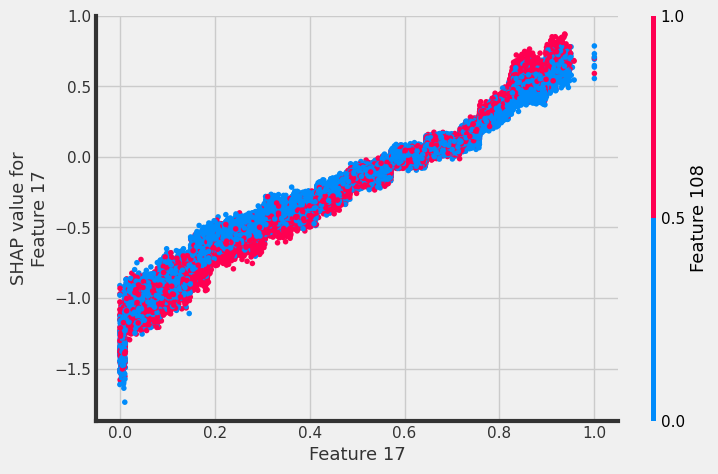

In [265]:
shap.dependence_plot("Feature 17", shap_values[0], X_test_selected)

100%|===================| 92216/92254 [13:05<00:00]        

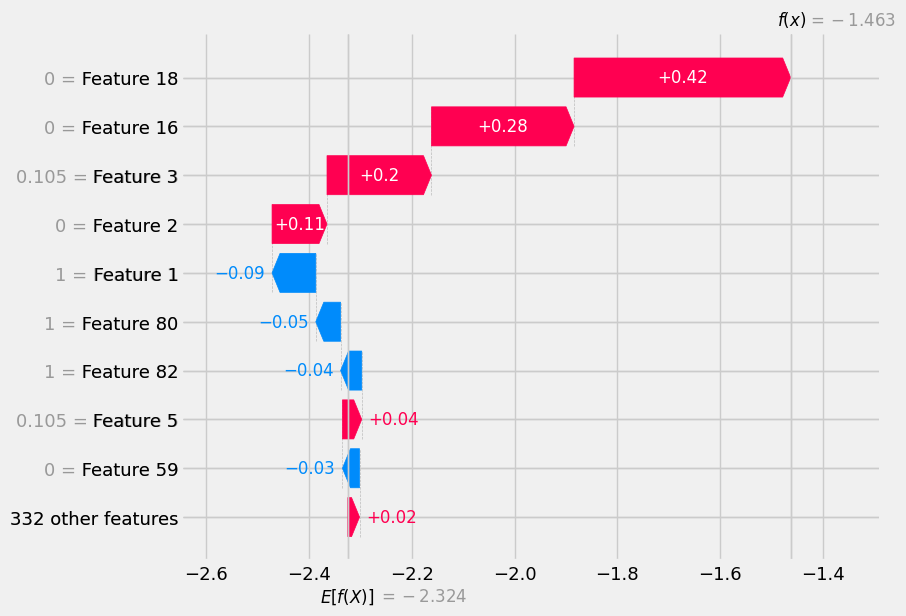

In [266]:
explainer = shap.TreeExplainer(lgbm, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

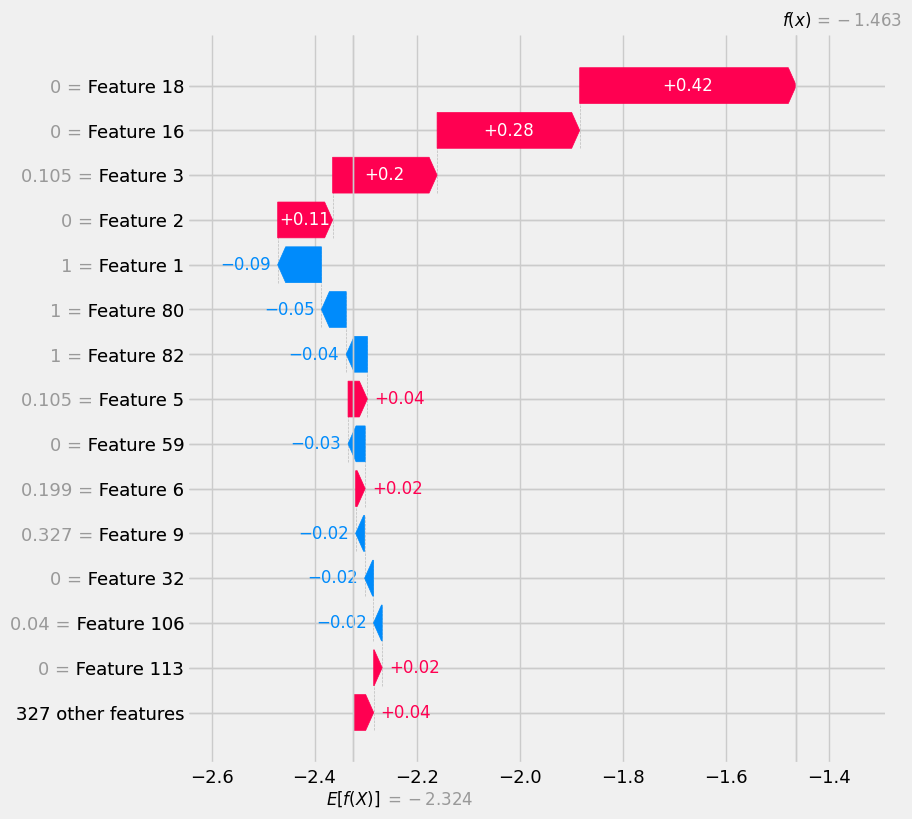

In [267]:
shap.plots.waterfall(shap_values[0], max_display=15)

**Conclusion**\
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.